In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mstats
import pystan
%matplotlib inline

In [2]:
plt.style.use("ggplot")

In [3]:
df = pd.read_excel("./data/multilevel_modeling.xlsx")

In [4]:
df.head()

,age,height,id
0,1,72.737927,1
1,3,85.694575,1
2,5,98.635829,1
3,8,117.302636,1
4,10,130.076144,1


In [6]:
len(df["id"].unique())

15

In [7]:
groups = df.groupby(df["id"])

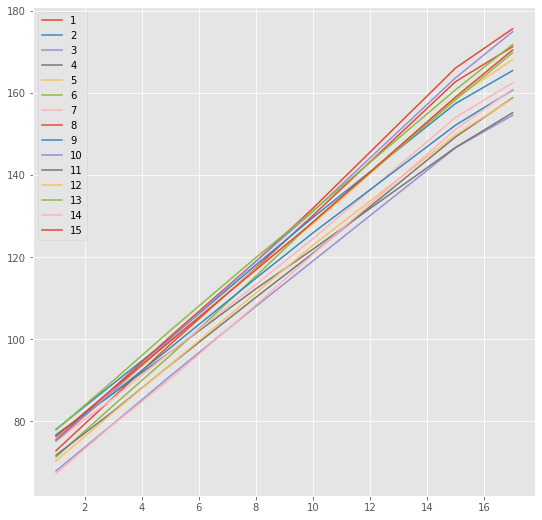

In [11]:
plt.figure(figsize=(9, 9))
for name, group in groups:
    plt.plot(group["age"], group["height"], label=name)
plt.legend()

In [19]:
model_code = """
data {
    int N;
    int N_id;
    real X[N];
    real Y[N];
    int<lower=1, upper=N_id> s_id[N];
}

parameters {
    real a0;
    real b0;
    real a_id[N_id];
    real b_id[N_id];
    real<lower=0> s_a;
    real<lower=0> s_b;
    real<lower=0> s_Y;
}

transformed parameters {
    real a[N_id];
    real b[N_id];
    for (n in 1:N_id){
        a[n] = a0 + a_id[n];
        b[n] = b0 + b_id[n];
    }
}

model {
    for (id in 1:N_id){
        a_id[id] ~ normal(0, s_a);
        b_id[id] ~ normal(0, s_b);
    }
    
    for (n in 1:N){
        Y[n] ~ normal(a[s_id[n]] * X[n] + b[s_id[n]],  s_Y);
    }
}
"""

In [20]:
sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6f53dc4882efc21aa73f3f75b887d163 NOW.


In [21]:
stan_data = {"N": df.shape[0], "N_id": len(df["id"].unique()), "X": df["age"], "Y": df["height"], "s_id": df["id"]}

In [22]:
fit = sm.sampling(data = stan_data, iter = 3000, warmup = 1000, chains = 3, seed = 123)

In [23]:
fit

Inference for Stan model: anon_model_6f53dc4882efc21aa73f3f75b887d163.
3 chains, each with iter=3000; warmup=1000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=6000.

           mean se_mean     sd   2.5%     25%    50%    75%  97.5%  n_eff   Rhat
a0         5.77  4.4e-3   0.12   5.54    5.69   5.77   5.84   6.01    716    1.0
b0         68.2    0.03   0.93  66.41   67.59  68.17  68.77  70.14    875    1.0
a_id[1]    0.46  4.5e-3   0.13    0.2    0.38   0.47   0.55   0.72    856    1.0
a_id[2]   -0.19  4.6e-3   0.13  -0.47   -0.28  -0.19  -0.11   0.06    825    1.0
a_id[3]   -0.29  4.4e-3   0.13  -0.56   -0.38  -0.29  -0.21  -0.04    871    1.0
a_id[4]    -0.8  4.5e-3   0.13  -1.06   -0.88   -0.8  -0.71  -0.55    845    1.0
a_id[5]    0.09  4.5e-3   0.13  -0.19  4.8e-4   0.09   0.17   0.34    848    1.0
a_id[6]    0.41  4.5e-3   0.13   0.14    0.32   0.41   0.49   0.67    866    1.0
a_id[7]   -0.21  4.4e-3   0.13  -0.48   -0.29  -0.21  -0.12   0.05    877    1.0
a

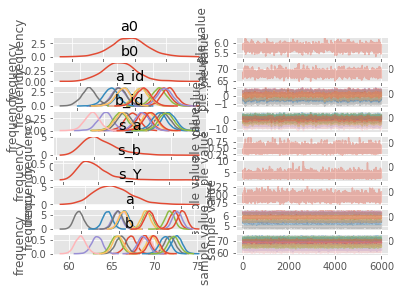

In [24]:
fig = fit.plot()

In [26]:
ms_a = fit.extract("a")["a"]
ms_b = fit.extract("b")["b"]

In [27]:
x = np.arange(18)
df_b = pd.DataFrame([])
for i in range(18):
    df_b[i]= ms_a[:, 0] * x[i] + ms_b[:, 0]

In [29]:
low_y50, high_y50 = mstats.mquantiles(df_b, [0.25, 0.75], axis = 0)
low_y95, high_y95 = mstats.mquantiles(df_b, [0.025, 0.975], axis = 0)

In [30]:
df_0 = groups.get_group(1)

In [31]:
df_0.head()

,age,height,id
0,1,72.737927,1
1,3,85.694575,1
2,5,98.635829,1
3,8,117.302636,1
4,10,130.076144,1


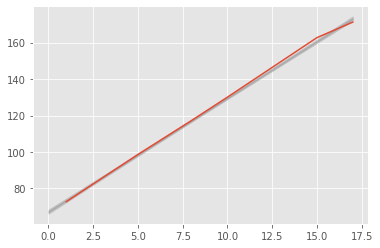

In [33]:
plt.plot(df_0["age"], df_0["height"])
plt.fill_between(x, low_y50, high_y50, alpha=0.6, color="darkgray")
plt.fill_between(x, low_y95, high_y95, alpha=0.3, color="gray")